## AN IMAGE IS WORTH 16X16 WORDS:TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE
https://arxiv.org/pdf/2010.11929.pdf

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12
    assert int(torchvision.__version__.split(".")[1]) >= 13
    print(f"torch version: {torch.__version__}" )
    print(f"torchvision version: {torchvision.__version__}" )
    
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1
torchvision version: 0.15.2


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms


try:
    from torchinfo import summary
except:
    !pip3 install -q torchinfo
    from torchinfo import summary
    
import data_setup 
import engine
from helper_functions import download_data, set_seeds, plot_loss_curves

/home/nitiz/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [6]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

print(f"Manually created transforms : {manual_transforms}")

Manually created transforms : Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [9]:
BATCH_SIZE = 32 #Original Paper has batch size of 4096 but obviously .....

train_dataloader , test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f891b7245d0>,
 ['pizza', 'steak', 'sushi'])

In [11]:
image_batch , label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape , label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

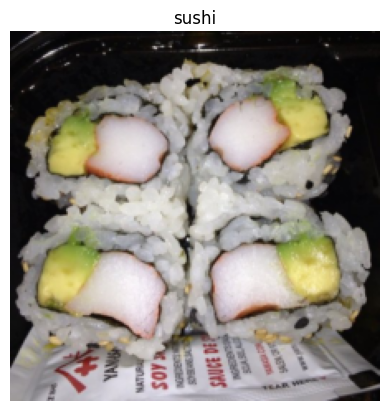

In [13]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)